## Sending data to Kafka server

This notebook uses the [Python client for the Apache Kafka distributed stream processing system](http://kafka-python.readthedocs.io/en/master/index.html) to send messages to a Kafka cluster. 

In this example, the messages are data generated from a linear model with $n$ input variables, i.e., 

$$
y =x^T \beta +w
$$
with $x, \beta \in \mathbb{R}^n$, and $y, w \in \mathbb{R}$. $w$ is Gaussian noise.

Messages are sent every $interval$ seconds. They are list of size (n+2) where:
* First element is the counter 
* Second element is $y$ 
* Third to last elements are $x$ values (size $n$)


In [1]:
from kafka import KafkaProducer
import time
import numpy as np
import pandas as pd

In [2]:
#Takes about one minute to load
data=pd.read_csv("../../data/data.conv.txt.gz",header=None,sep=" ")
data.columns=["Date","Hour","Sensor","Value","Voltage"]
data=data.sort_values(['Date','Hour']).reset_index(drop=True)

data['datetime']=pd.to_datetime(data.Date+' '+data.Hour)
data['relative_datetime']=data['datetime']-data['datetime'][0]
data['seconds']=data['relative_datetime'].dt.total_seconds()

sensorId_type=data.Sensor.str.split("-",expand=True)
sensorId_type.columns=['SensorId','Type']
data['SensorId']=sensorId_type['SensorId'].astype(int)
data['Type']=sensorId_type['Type'].astype(int)

In [3]:
#Drop features not needed for the simulation
data=data.drop(['datetime','relative_datetime','Sensor','Date','Hour','Voltage'],axis=1)

In [4]:
data[-5:]

,Value,seconds,SensorId,Type
6939463,0.04022,3150123.390,56,2
6939464,35.85300,3150123.706,56,1
6939465,37.72000,3150152.840,56,2
6939466,36.43960,3150153.033,56,1
6939467,23.53600,3150153.360,56,0


In [19]:
temp=data[(data.Type==0)]
temp=temp.reset_index(drop=True)

In [20]:
# Sensors to predict
sensors_to_predict = [1, 24]
temp = temp[temp.SensorId.isin(sensors_to_predict)]
print(temp[:10])

       Value  seconds  SensorId  Type
64   18.1362   53.492        24     0
79   19.2436   79.124         1     0
81   18.1166   79.230        24     0
114  18.1264  108.864        24     0
146  18.1362  138.638        24     0
188  19.2240  169.155         1     0
224  19.2142  200.931         1     0
247  18.1460  229.040        24     0
305  19.1848  264.276         1     0
321  18.1264  290.305        24     0


In [21]:
num_day_to_predict = 8 # must be at least 1
temp_tot = temp[temp.seconds < num_day_to_predict*86400]

temp_tot.iloc[0]

Value       18.1362
seconds     53.4920
SensorId    24.0000
Type         0.0000
Name: 64, dtype: float64

In [22]:
def rollup(temp, interval, day_begin=0):
    # roll up data according to a time interval
    first_temp = day_begin*86400
    last_temp = temp.iloc[-1].seconds
    time_bins = int((last_temp-first_temp)/interval) + 1
    temp_sync = np.zeros((time_bins, 5)) # Value, bin, SensorID, Type, number of elem in bin

    for i in range(len(temp)):
        data = temp.iloc[i]
        bin = int((data.seconds-first_temp)/interval)
        n = temp_sync[bin][-1] + 1
        new_value = (temp_sync[bin][0] * (n-1) + data.Value)/n # running avg
        temp_sync[bin][0] = new_value
        temp_sync[bin][1] = bin
        temp_sync[bin][2] = int(data.SensorId)
        temp_sync[bin][3] = int(data.Type)
        temp_sync[bin][4] = n
    return temp_sync


def delta_max(temp):
    # evaluate the maximum time interval between two data
    maxT = 0
    for i in range(1,len(temp)):
        time_now = temp.iloc[i].seconds
        time_before = temp.iloc[i-1].seconds
        delta = time_now - time_before
        if delta > maxT:
            maxT = delta
    return maxT


def interpolate(temp_sync, nbin_left, nbin_right):
    # interpolate missing data in rolled up data using the data of K neighbours
    # rolled up data referes to the output of rollup function
    # nbin_left: number of past data used for interpolation
    # nbin_right: number of futur data used for interpolation
    for bin in range(len(temp_sync)):
        # if no value provided
        left_range = max(0, bin-nbin_left)
        right_range = min(len(temp_sync), bin+nbin_right)
        if temp_sync[bin][-1] == 0:
            bins = []
            vals = []
            sensorId = 0
            for n in range(int(left_range), int(right_range)):
                if temp_sync[n][-1] != 0:
                    bins.append(n)
                    vals.append(temp_sync[n][0])
                    sensorId = int(temp_sync[n][2])
            val_interp = np.interp(bin, bins, vals)
            temp_sync[bin][0] = val_interp
            temp_sync[bin][1] = bin
            temp_sync[bin][2] = sensorId
            temp_sync[bin][3] = 0
            temp_sync[bin][4] = 1
    return temp_sync

In [18]:
delta_max_train = delta_max(temp_train)
print(delta_max_train)

88.832


In [23]:
# Create a cleaned temperature vector:
# we want one data every interval, this is not always the case in the raw data
time_res = 30 # time resolution
temp_tot_sync = [0] * len(sensors_to_predict)
for i in range(len(sensors_to_predict)):
    temp_tot_i = temp_tot[temp_tot.SensorId == sensors_to_predict[i]]
    temp_tot_sync[i] = rollup(temp_tot_i, time_res, day_begin=0)

    print('Number of intervals of %ds for sensor %d: %d' %(time_res, sensors_to_predict[i], len(temp_tot_sync[i])))

Number of intervals of 30s for sensor 1: 23040
Number of intervals of 30s for sensor 24: 23040


In [24]:
print('Sensor 1:')
print(temp_tot_sync[0][:5])
print('Sensor 24:')
print(temp_tot_sync[1][:5])

Sensor 1:
[[  0.       0.       0.       0.       0.    ]
 [  0.       0.       0.       0.       0.    ]
 [ 19.2436   2.       1.       0.       1.    ]
 [  0.       0.       0.       0.       0.    ]
 [  0.       0.       0.       0.       0.    ]]
Sensor 24:
[[  0.       0.       0.       0.       0.    ]
 [ 18.1362   1.      24.       0.       1.    ]
 [ 18.1166   2.      24.       0.       1.    ]
 [ 18.1264   3.      24.       0.       1.    ]
 [ 18.1362   4.      24.       0.       1.    ]]


In [25]:
K = 6 # interpolation memory, choose according to interval (and eventually maxT)
for i in range(len(sensors_to_predict)):
    temp_tot_sync[i] = interpolate(temp_tot_sync[i], K, K)
    
print('Sensor 1:')
print(temp_tot_sync[0][:5])
print('Sensor 24:')
print(temp_tot_sync[1][:5])

Sensor 1:
[[ 19.2436       0.           1.           0.           1.        ]
 [ 19.2436       1.           1.           0.           1.        ]
 [ 19.2436       2.           1.           0.           1.        ]
 [ 19.23706667   3.           1.           0.           1.        ]
 [ 19.23053333   4.           1.           0.           1.        ]]
Sensor 24:
[[ 18.1362   0.      24.       0.       1.    ]
 [ 18.1362   1.      24.       0.       1.    ]
 [ 18.1166   2.      24.       0.       1.    ]
 [ 18.1264   3.      24.       0.       1.    ]
 [ 18.1362   4.      24.       0.       1.    ]]


In [26]:
producer = KafkaProducer(bootstrap_servers='kafka1:19092,kafka2:29092,kafka3:39092')

In [ ]:
# Feeding training data:
num_train_days = 2
interval = 0.5 # interval for each batch

n = 1 # number of previous day to analyze
m = 10 # number of short-term parameters 
N = m + n*m # total number of parameters

step = int(86400/time_res) # number of bins in one day
start_t = int(n*step + m/2) # start day of learning + margin m which is the size of window of observation
end_t = start_t + num_train_days*step


for t in range(start_t, end_t):
    tic = time.time()
    for i in range(len(sensors_to_predict)):
        xm = temp_tot_sync[i][t-1:t-1-m:-1,0] # m last short-term temperature
        xn = temp_tot_sync[i][int(t-step+m/2):int(t-step-m/2):-1,0] # m temperature of last day
        #xn = temp_tot_sync[t-step:t-(n+1)*step:-step, 0] # n last long-term temperature
        x = np.hstack((xm,xn))
        y = temp_tot_sync[i][t, 0] # current temperature
        key = str(sensors_to_predict[i])
        message = np.array2string(np.append([t,y],x),separator=",")
        producer.send('RLSTrain', key=key.encode(), value=message.encode())
        print(t, y, len(x))
    toc = time.time() - tic
    time.sleep(interval - toc)
    

2885 18.44 20
2885 18.1084333333 20
2886 18.44 20
2886 18.1068 20
2887 18.44 20
2887 18.0872 20
2888 18.44 20
2888 18.0872 20
2889 18.4449 20
2889 18.0872 20
2890 18.4498 20
2890 18.1068 20
2891 18.4302 20
2891 18.1019 20
2892 18.4302 20
2892 18.097 20
2893 18.4318333333 20
2893 18.09455 20
2894 18.4334666667 20
2894 18.0921 20
2895 18.4351 20
2895 18.0872 20
2896 18.4367333333 20
2896 18.08965 20
2897 18.4383666667 20
2897 18.0921 20
2898 18.44 20
2898 18.0872 20
2899 18.4302 20
2899 18.1068 20
2900 18.4302 20
2900 18.1019 20
2901 18.4302 20
2901 18.097 20
2902 18.4302 20
2902 18.0872 20
2903 18.4302 20
2903 18.0774 20
2904 18.4302 20
2904 18.0676 20
2905 18.4302 20
2905 18.0610666667 20
2906 18.4302 20
2906 18.0545333333 20
2907 18.4302 20
2907 18.048 20
2908 18.4302 20
2908 18.0382 20
2909 18.4302 20
2909 18.0284 20
2910 18.4302 20
2910 18.0284 20
2911 18.4236666667 20
2911 18.0284 20
2912 18.4171333333 20
2912 18.0284 20
2913 18.4106 20
2913 18.0284 20
2914 18.4040666667 20
2914 18

3132 18.048 20
3132 17.3424 20
3133 18.0676 20
3133 17.3424 20
3134 18.0708666667 20
3134 17.3424 20
3135 18.0741333333 20
3135 17.3424 20
3136 18.0774 20
3136 17.362 20
3137 18.0741333333 20
3137 17.3571 20
3138 18.0708666667 20
3138 17.3522 20
3139 18.0676 20
3139 17.3522 20
3140 18.0578 20
3140 17.3489333333 20
3141 18.048 20
3141 17.3456666667 20
3142 18.0512666667 20
3142 17.3424 20
3143 18.0545333333 20
3143 17.362 20
3144 18.0578 20
3144 17.362 20
3145 18.0676 20
3145 17.362 20
3146 18.0676 20
3146 17.3522 20
3147 18.0676 20
3147 17.3473 20
3148 18.0676 20
3148 17.3424 20
3149 18.0610666667 20
3149 17.33995 20
3150 18.0545333333 20
3150 17.3375 20
3151 18.048 20
3151 17.33505 20
3152 18.0676 20
3152 17.3326 20
3153 18.0627 20
3153 17.3326 20
3154 18.0578 20
3154 17.3326 20
3155 18.048 20
3155 17.3228 20
3156 18.0382 20
3156 17.313 20
3157 18.0284 20
3157 17.3081 20
3158 18.0284 20
3158 17.3032 20
3159 18.0284 20
3159 17.3032 20
3160 18.0284 20
3160 17.2983 20
3161 18.0186 20
316

3379 17.8128 20
3379 16.8524 20
3380 17.803 20
3380 16.8328 20
3381 17.803 20
3381 16.8426 20
3382 17.7834 20
3382 16.8426 20
3383 17.7866666667 20
3383 16.84064 20
3384 17.7899333333 20
3384 16.83868 20
3385 17.7932 20
3385 16.83672 20
3386 17.7736 20
3386 16.83476 20
3387 17.7834 20
3387 16.8328 20
3388 17.7932 20
3388 16.8132 20
3389 17.7834 20
3389 16.823 20
3390 17.7736 20
3390 16.7936 20
3391 17.7785 20
3391 16.8034 20
3392 17.7834 20
3392 16.8083 20
3393 17.7736 20
3393 16.8132 20
3394 17.7736 20
3394 16.8132 20
3395 17.7638 20
3395 16.8132 20
3396 17.754 20
3396 16.7936 20
3397 17.754 20
3397 16.7936 20
3398 17.7605333333 20
3398 16.7936 20
3399 17.7670666667 20
3399 16.7936 20
3400 17.7736 20
3400 16.7936 20
3401 17.7736 20
3401 16.7887 20
3402 17.7736 20
3402 16.7838 20
3403 17.7736 20
3403 16.7838 20
3404 17.7736 20
3404 16.7789 20
3405 17.7736 20
3405 16.774 20
3406 17.7736 20
3406 16.7544 20
3407 17.7736 20
3407 16.7544 20
3408 17.7638 20
3408 16.7544 20
3409 17.7736 20
34

3622 17.4077333333 20
3622 15.8822 20
3623 17.4044666667 20
3623 15.892 20
3624 17.4012 20
3624 15.8871 20
3625 17.4012 20
3625 15.8822 20
3626 17.4012 20
3626 15.8773 20
3627 17.4012 20
3627 15.8724 20
3628 17.411 20
3628 15.8724 20
3629 17.4159 20
3629 15.8724 20
3630 17.4208 20
3630 15.8528 20
3631 17.4208 20
3631 15.843 20
3632 17.411 20
3632 15.8528 20
3633 17.4061 20
3633 15.843 20
3634 17.4012 20
3634 15.8332 20
3635 17.3963 20
3635 15.8136 20
3636 17.3914 20
3636 15.8038 20
3637 17.3816 20
3637 15.794 20
3638 17.36935 20
3638 15.79645 20
3639 17.3571 20
3639 15.7989 20
3640 17.35955 20
3640 15.794 20
3641 17.362 20
3641 15.794 20
3642 17.3522 20
3642 15.7891 20
3643 17.3424 20
3643 15.7842 20
3644 17.362 20
3644 15.7646 20
3645 17.3424 20
3645 15.7597 20
3646 17.3326 20
3646 15.7548 20
3647 17.3228 20
3647 15.7646 20
3648 17.3228 20
3648 15.7744 20
3649 17.3228 20
3649 15.7646 20
3650 17.3228 20
3650 15.7548 20
3651 17.3032 20
3651 15.7254 20
3652 17.3228 20
3652 15.7352 20
365

3873 21.184 20
3873 24.2318 20
3874 21.233 20
3874 24.3298 20
3875 21.2428 20
3875 24.3347 20
3876 21.1448 20
3876 24.3396 20
3877 21.184 20
3877 24.32 20
3878 21.184 20
3878 24.3102 20
3879 21.1056 20
3879 24.3004 20
3880 21.0566 20
3880 24.3102 20
3881 21.0664 20
3881 24.2906 20
3882 21.09335 20
3882 24.2122 20
3883 21.1203 20
3883 24.222 20
3884 21.14235 20
3884 24.2318 20
3885 21.1644 20
3885 24.2416 20
3886 21.1644 20
3886 24.271 20
3887 21.1644 20
3887 24.3004 20
3888 21.1644 20
3888 24.32 20
3889 21.2036 20
3889 24.3396 20
3890 21.1938 20
3890 24.3592 20
3891 21.2134 20
3891 24.3935 20
3892 21.2085 20
3892 24.4278 20
3893 21.2036 20
3893 24.4082 20
3894 21.2722 20
3894 24.418 20
3895 21.2673 20
3895 24.4082 20
3896 21.2624 20
3896 24.4278 20
3897 21.2477 20
3897 24.4131 20
3898 21.1938 20
3898 24.3984 20
3899 21.1938 20
3899 24.418 20
3900 21.1938 20
3900 24.4376 20
3901 21.1497 20
3901 24.4572 20
3902 21.1644 20
3902 24.467 20
3903 21.2036 20
3903 24.5062 20
3904 21.2183 20
390

4124 22.1738 20
4124 25.8733 20
4125 22.1738 20
4125 25.8684 20
4126 22.1591 20
4126 25.8635 20
4127 22.1444 20
4127 25.888 20
4128 22.1542 20
4128 25.88065 20
4129 22.1738 20
4129 25.8733 20
4130 22.1934 20
4130 25.9174 20
4131 22.164 20
4131 25.9076 20
4132 22.1346 20
4132 25.8978 20
4133 22.1738 20
4133 25.937 20
4134 22.164 20
4134 25.8978 20
4135 22.1738 20
4135 25.8488 20
4136 22.1836 20
4136 25.8488 20
4137 22.1934 20
4137 25.9272 20
4138 22.1934 20
4138 25.9174 20
4139 22.1934 20
4139 25.937 20
4140 22.1934 20
4140 25.9566 20
4141 22.1542 20
4141 25.9762 20
4142 22.2424 20
4142 26.0105 20
4143 22.3306 20
4143 26.0448 20
4144 22.2865 20
4144 26.05215 20
4145 22.2424 20
4145 26.0595 20
4146 22.2522 20
4146 26.06685 20
4147 22.3502 20
4147 26.0742 20
4148 22.311 20
4148 26.0497 20
4149 22.3306 20
4149 26.0252 20
4150 22.36 20
4150 26.0007 20
4151 22.3698 20
4151 25.9762 20
4152 22.3747 20
4152 25.9566 20
4153 22.3796 20
4153 25.937 20
4154 22.3894 20
4154 25.9076 20
4155 22.3992 2

4376 24.48905 20
4376 28.9064 20
4377 24.4572 20
4377 28.8476 20
4378 24.5356 20
4378 28.8263666667 20
4379 24.5846 20
4379 28.8051333333 20
4380 24.6777 20
4380 28.7839 20
4381 24.7708 20
4381 28.7496 20
4382 24.81 20
4382 28.7153 20
4383 24.9031 20
4383 28.681 20
4384 24.9962 20
4384 28.632 20
4385 25.104 20
4385 28.60015 20
4386 25.1236 20
4386 28.5683 20
4387 25.0648 20
4387 28.53645 20
4388 25.1432 20
4388 28.5046 20
4389 25.0256 20
4389 28.4556 20
4390 24.9374 20
4390 28.3576 20
4391 24.8492 20
4391 28.3576 20
4392 24.761 20
4392 28.3576 20
4393 24.7953 20
4393 28.3184 20
4394 24.8296 20
4394 28.2792 20
4395 24.8198 20
4395 28.2939 20
4396 24.81 20
4396 28.3086 20
4397 24.8394 20
4397 28.32085 20
4398 24.8884 20
4398 28.3331 20
4399 24.9864 20
4399 28.534 20
4400 24.9374 20
4400 28.4752 20
4401 24.8688 20
4401 28.3968 20
4402 24.9864 20
4402 28.4752 20
4403 25.0158 20
4403 28.4703 20
4404 24.8296 20
4404 28.4654 20
4405 24.8296 20
4405 28.4817333333 20
4406 24.8345 20
4406 28.498

4628 26.0154 20
4628 29.67815 20
4629 25.9827333333 20
4629 29.6757 20
4630 25.9500666667 20
4630 29.68305 20
4631 25.9174 20
4631 29.6904 20
4632 25.8847333333 20
4632 29.5728 20
4633 25.8520666667 20
4633 29.55565 20
4634 25.8194 20
4634 29.5385 20
4635 25.8096 20
4635 29.44785 20
4636 25.7998 20
4636 29.3572 20
4637 25.7606 20
4637 29.1416 20
4638 25.7263 20
4638 29.1808 20
4639 25.692 20
4639 29.2102 20
4640 25.4372 20
4640 29.2102 20
4641 25.4176 20
4641 29.416 20
4642 25.447 20
4642 29.5042 20
4643 25.4764 20
4643 29.5924 20
4644 25.5058 20
4644 29.6871333333 20
4645 25.6332 20
4645 29.7818666667 20
4646 25.7018 20
4646 29.8766 20
4647 25.741 20
4647 29.8668 20
4648 25.7802 20
4648 29.857 20
4649 25.8194 20
4649 29.9844 20
4650 25.8194 20
4650 30.0236 20
4651 25.8210333333 20
4651 29.9942 20
4652 25.8226666667 20
4652 29.955 20
4653 25.8243 20
4653 29.9158 20
4654 25.82675 20
4654 29.8962 20
4655 25.8292 20
4655 29.8766 20
4656 25.9174 20
4656 30.004 20
4657 25.8145 20
4657 30.13

4879 25.0011 20
4879 29.9501 20
4880 24.97415 20
4880 29.96725 20
4881 24.9472 20
4881 29.9844 20
4882 25.01188 20
4882 30.0562666667 20
4883 25.07656 20
4883 30.1281333333 20
4884 25.14124 20
4884 30.2 20
4885 25.20592 20
4885 30.2686 20
4886 25.2706 20
4886 30.2 20
4887 25.2706 20
4887 30.1608 20
4888 25.2755 20
4888 29.9844 20
4889 25.2804 20
4889 29.9942 20
4890 25.3147 20
4890 29.8962 20
4891 25.349 20
4891 29.8962 20
4892 25.37595 20
4892 29.8962 20
4893 25.4029 20
4893 29.9305 20
4894 25.4764 20
4894 29.9648 20
4895 25.5058 20
4895 29.9648 20
4896 25.5352 20
4896 30.0056333333 20
4897 25.5678666667 20
4897 30.0464666667 20
4898 25.6005333333 20
4898 30.0873 20
4899 25.6332 20
4899 30.09465 20
4900 25.594 20
4900 30.102 20
4901 25.5695 20
4901 30.0677 20
4902 25.545 20
4902 30.0334 20
4903 25.5401 20
4903 30.0481 20
4904 25.50825 20
4904 30.0628 20
4905 25.4764 20
4905 29.9942 20
4906 25.3931 20
4906 29.92805 20
4907 25.413925 20
4907 29.8619 20
4908 25.43475 20
4908 29.906 20
49

5131 21.5858 20
5131 22.752 20
5132 21.5858 20
5132 22.7454666667 20
5133 21.576 20
5133 22.7389333333 20
5134 21.5662 20
5134 22.7324 20
5135 21.5662 20
5135 22.7275 20
5136 21.5515 20
5136 22.7226 20
5137 21.5368 20
5137 22.7128 20
5138 21.5466 20
5138 22.703 20
5139 21.5417 20
5139 22.6932 20
5140 21.5368 20
5140 22.6834 20
5141 21.5368 20
5141 22.6736 20
5142 21.5368 20
5142 22.6638 20
5143 21.5368 20
5143 22.654 20
5144 21.5368 20
5144 22.6442 20
5145 21.5237333333 20
5145 22.6295 20
5146 21.5106666667 20
5146 22.6148 20
5147 21.4976 20
5147 22.5756 20
5148 21.4976 20
5148 22.556 20
5149 21.4976 20
5149 22.5266 20
5150 21.4976 20
5150 22.51435 20
5151 21.4878 20
5151 22.5021 20
5152 21.478 20
5152 22.48985 20
5153 21.4682 20
5153 22.4776 20
5154 21.4584 20
5154 22.4678 20
5155 21.4486 20
5155 22.458 20
5156 21.4388 20
5156 22.4514666667 20
5157 21.4094 20
5157 22.4449333333 20
5158 21.3947 20
5158 22.4384 20
5159 21.38 20
5159 22.4318666667 20
5160 21.3751 20
5160 22.4253333333 20

5382 20.5568 20
5382 21.0468 20
5383 20.56415 20
5383 21.0468 20
5384 20.5715 20
5384 21.0468 20
5385 20.55925 20
5385 21.0419 20
5386 20.547 20
5386 21.037 20
5387 20.5372 20
5387 21.0272 20
5388 20.5372 20
5388 21.0272 20
5389 20.5372 20
5389 21.0272 20
5390 20.547 20
5390 21.0174 20
5391 20.5568 20
5391 21.0076 20
5392 20.547 20
5392 21.0076 20
5393 20.5568 20
5393 21.0027 20
5394 20.5568 20
5394 20.9978 20
5395 20.5568 20
5395 21.0010666667 20
5396 20.5568 20
5396 21.0043333333 20
5397 20.5568 20
5397 21.0076 20
5398 20.5421 20
5398 20.9978 20
5399 20.5372 20
5399 20.988 20
5400 20.5372 20
5400 20.988 20
5401 20.5372 20
5401 20.988 20
5402 20.5274 20
5402 20.9782 20
5403 20.5176 20
5403 20.97575 20
5404 20.5127 20
5404 20.9733 20
5405 20.5078 20
5405 20.9684 20
5406 20.5029 20
5406 20.9586 20
5407 20.498 20
5407 20.96056 20
5408 20.498 20
5408 20.96252 20
5409 20.4784 20
5409 20.96448 20
5410 20.4784 20
5410 20.96644 20
5411 20.4784 20
5411 20.9684 20
5412 20.4637 20
5412 20.9684 2

5634 19.7532 20
5634 19.7728 20
5635 19.7401333333 20
5635 19.7679 20
5636 19.7270666667 20
5636 19.763 20
5637 19.714 20
5637 19.7581 20
5638 19.6552 20
5638 19.7532 20
5639 19.6617333333 20
5639 19.763 20
5640 19.6682666667 20
5640 19.7728 20
5641 19.6748 20
5641 19.7826 20
5642 19.6846 20
5642 19.7826 20
5643 19.6944 20
5643 19.7826 20
5644 19.6944 20
5644 19.7728 20
5645 19.6944 20
5645 19.763 20
5646 19.714 20
5646 19.7532 20
5647 19.7042 20
5647 19.7532 20
5648 19.6944 20
5648 19.7581 20
5649 19.7042 20
5649 19.763 20
5650 19.714 20
5650 19.7532 20
5651 19.714 20
5651 19.7336 20
5652 19.714 20
5652 19.7303333333 20
5653 19.7042 20
5653 19.7270666667 20
5654 19.6944 20
5654 19.7238 20
5655 19.6846 20
5655 19.714 20
5656 19.6748 20
5656 19.7042 20
5657 19.6715333333 20
5657 19.6944 20
5658 19.6682666667 20
5658 19.6944 20
5659 19.665 20
5659 19.6944 20
5660 19.6748 20
5660 19.6944 20
5661 19.6699 20
5661 19.6944 20
5662 19.665 20
5662 19.6944 20
5663 19.6601 20
5663 19.6993 20
5664

5883 18.9153 20
5883 18.3273 20
5884 18.8908 20
5884 18.3028 20
5885 18.881 20
5885 18.2783 20
5886 18.8712 20
5886 18.244 20
5887 18.8614 20
5887 18.2342 20
5888 18.8581333333 20
5888 18.2244 20
5889 18.8548666667 20
5889 18.2048 20
5890 18.8516 20
5890 18.1852 20
5891 18.8516 20
5891 18.1656 20
5892 18.8516 20
5892 18.146 20
5893 18.8418 20
5893 18.1264 20
5894 18.8352666667 20
5894 18.1166 20
5895 18.8287333333 20
5895 18.1068 20
5896 18.8222 20
5896 18.1019 20
5897 18.8124 20
5897 18.097 20
5898 18.8091333333 20
5898 18.0774 20
5899 18.8058666667 20
5899 18.0627 20
5900 18.8026 20
5900 18.048 20
5901 18.8124 20
5901 18.048 20
5902 18.8222 20
5902 18.0284 20
5903 18.7928 20
5903 18.0284 20
5904 18.7895333333 20
5904 18.0137 20
5905 18.7862666667 20
5905 18.00488 20
5906 18.783 20
5906 17.99606 20
5907 18.7536 20
5907 17.98724 20
5908 18.7536 20
5908 17.97842 20
5909 18.7438 20
5909 17.9696 20
5910 18.7438 20
5910 17.9696 20
5911 18.7536 20
5911 17.95 20
5912 18.75115 20
5912 17.9402

6132 18.1329333333 20
6132 17.1856 20
6133 18.1296666667 20
6133 17.1856 20
6134 18.1264 20
6134 17.1856 20
6135 18.1313 20
6135 17.1856 20
6136 18.1362 20
6136 17.1798833333 20
6137 18.1411 20
6137 17.1741666667 20
6138 18.146 20
6138 17.16845 20
6139 18.1558 20
6139 17.1627333333 20
6140 18.1362 20
6140 17.1692666667 20
6141 18.146 20
6141 17.1758 20
6142 18.14355 20
6142 17.1464 20
6143 18.1411 20
6143 17.1464 20
6144 18.1362 20
6144 17.1398666667 20
6145 18.1313 20
6145 17.1333333333 20
6146 18.1264 20
6146 17.1268 20
6147 18.1166 20
6147 17.1072 20
6148 18.1166 20
6148 17.1023 20
6149 18.1166 20
6149 17.0974 20
6150 18.1166 20
6150 17.1072 20
6151 18.1068 20
6151 17.1023 20
6152 18.1068 20
6152 17.0974 20
6153 18.1068 20
6153 17.0925 20
6154 18.1019 20
6154 17.09005 20
6155 18.097 20
6155 17.0876 20
6156 18.0904666667 20
6156 17.0974 20
6157 18.0839333333 20
6157 17.0974 20
6158 18.0774 20
6158 17.0941333333 20
6159 18.0725 20
6159 17.0908666667 20
6160 18.0676 20
6160 17.0876 20


6380 17.5384 20
6380 16.235 20
6381 17.5384 20
6381 16.2252 20
6382 17.5335 20
6382 16.21785 20
6383 17.5286 20
6383 16.2105 20
6384 17.5188 20
6384 16.2252 20
6385 17.5286 20
6385 16.2154 20
6386 17.5237 20
6386 16.2056 20
6387 17.5188 20
6387 16.1909 20
6388 17.5188 20
6388 16.1762 20
6389 17.5188 20
6389 16.1762 20
6390 17.5188 20
6390 16.186 20
6391 17.509 20
6391 16.18845 20
6392 17.4992 20
6392 16.1909 20
6393 17.5024666667 20
6393 16.1958 20
6394 17.5057333333 20
6394 16.1958 20
6395 17.509 20
6395 16.1958 20
6396 17.4992 20
6396 16.2023333333 20
6397 17.4943 20
6397 16.2088666667 20
6398 17.4894 20
6398 16.2154 20
6399 17.4943 20
6399 16.2105 20
6400 17.4992 20
6400 16.2056 20
6401 17.509 20
6401 16.2056 20
6402 17.5188 20
6402 16.20315 20
6403 17.5286 20
6403 16.2007 20
6404 17.5384 20
6404 16.19825 20
6405 17.53105 20
6405 16.1958 20
6406 17.5237 20
6406 16.1909 20
6407 17.52125 20
6407 16.186 20
6408 17.5188 20
6408 16.186 20
6409 17.5384 20
6409 16.1958 20
6410 17.5384 20
6

6630 21.1448 20
6630 25.104 20
6631 21.1889 20
6631 25.1138 20
6632 21.233 20
6632 25.1236 20
6633 21.2722 20
6633 25.202 20
6634 21.2771 20
6634 25.2118 20
6635 21.282 20
6635 25.2216 20
6636 21.331 20
6636 25.2314 20
6637 21.3653 20
6637 25.2559 20
6638 21.3898 20
6638 25.2804 20
6639 21.4143 20
6639 25.398 20
6640 21.4388 20
6640 25.4372 20
6641 21.4682 20
6641 25.4764 20
6642 21.5123 20
6642 25.5156 20
6643 21.54415 20
6643 25.55725 20
6644 21.576 20
6644 25.5989 20
6645 21.6054 20
6645 25.61115 20
6646 21.6348 20
6646 25.6234 20
6647 21.6544 20
6647 25.7508 20
6648 21.674 20
6648 25.7851 20
6649 21.6936 20
6649 25.8194 20
6650 21.7426 20
6650 25.8194 20
6651 21.7916 20
6651 25.8194 20
6652 21.8030333333 20
6652 25.8618666667 20
6653 21.8144666667 20
6653 25.9043333333 20
6654 21.8259 20
6654 25.9468 20
6655 21.83325 20
6655 25.9468 20
6656 21.8406 20
6656 25.986 20
6657 21.8602 20
6657 26.0448 20
6658 21.919 20
6658 26.0693 20
6659 21.9288 20
6659 26.0938 20
6660 21.9386 20
6660 2

6881 25.0615333333 20
6881 30.8076 20
6882 25.0452 20
6882 30.8076 20
6883 25.0354 20
6883 30.8076 20
6884 25.0256 20
6884 30.8076 20
6885 25.0158 20
6885 30.8615 20
6886 25.0256 20
6886 30.9154 20
6887 25.0533666667 20
6887 30.8468 20
6888 25.0811333333 20
6888 30.8402666667 20
6889 25.1089 20
6889 30.8337333333 20
6890 25.1334 20
6890 30.8272 20
6891 25.1579 20
6891 31.0232 20
6892 25.1824 20
6892 31.0232 20
6893 25.1922 20
6893 31.0232 20
6894 25.1922 20
6894 31.0232 20
6895 25.1432 20
6895 31.0232 20
6896 25.0942 20
6896 31.0673 20
6897 25.0991 20
6897 31.1114 20
6898 25.104 20
6898 30.984 20
6899 25.1922 20
6899 30.9644 20
6900 25.2559 20
6900 30.9970666667 20
6901 25.3196 20
6901 31.0297333333 20
6902 25.2902 20
6902 31.0624 20
6903 25.21425 20
6903 31.1702 20
6904 25.1383 20
6904 31.1016 20
6905 25.104 20
6905 31.425 20
6906 25.202 20
6906 31.3515 20
6907 25.1922 20
6907 31.278 20
6908 25.2461 20
6908 31.2045 20
6909 25.4372 20
6909 31.2878 20
6910 25.4176 20
6910 31.4119333333 

7128 23.8496 20
7128 29.7247 20
7129 23.8594 20
7129 29.7042833333 20
7130 23.8692 20
7130 29.6838666667 20
7131 23.879 20
7131 29.6920333333 20
7132 23.8888 20
7132 29.7002 20
7133 23.8986 20
7133 29.7296 20
7134 23.91085 20
7134 29.759 20
7135 23.9231 20
7135 29.7492 20
7136 23.92555 20
7136 29.7835 20
7137 23.928 20
7137 29.8178 20
7138 23.9182 20
7138 29.8472 20
7139 23.8920666667 20
7139 29.8766 20
7140 23.8659333333 20
7140 29.9648 20
7141 23.8398 20
7141 29.9680666667 20
7142 23.83 20
7142 29.9713333333 20
7143 23.8202 20
7143 29.9746 20
7144 23.8104 20
7144 29.9844 20
7145 23.8202 20
7145 30.053 20
7146 23.84715 20
7146 30.1216 20
7147 23.8741 20
7147 30.1902 20
7148 23.8692 20
7148 30.2196 20
7149 23.8643 20
7149 30.249 20
7150 23.8692 20
7150 30.396 20
7151 23.8741 20
7151 30.42295 20
7152 23.879 20
7152 30.4499 20
7153 23.9672 20
7153 30.47685 20
7154 23.9541333333 20
7154 30.5038 20
7155 23.9410666667 20
7155 30.4989 20
7156 23.928 20
7156 30.494 20
7157 23.9312666667 20
71

7377 24.4131 20
7377 30.7447166667 20
7378 24.3494 20
7378 30.739 20
7379 24.3167333333 20
7379 30.7145 20
7380 24.2840666667 20
7380 30.6312 20
7381 24.2514 20
7381 30.5479 20
7382 24.2579333333 20
7382 30.4646 20
7383 24.2644666667 20
7383 30.3813 20
7384 24.271 20
7384 30.298 20
7385 24.32 20
7385 30.5087 20
7386 24.3298 20
7386 30.396 20
7387 24.3396 20
7387 30.3372 20
7388 24.33715 20
7388 30.2784 20
7389 24.3347 20
7389 30.2392 20
7390 24.33225 20
7390 30.1804 20
7391 24.3298 20
7391 30.1706 20
7392 24.3788 20
7392 30.1412 20
7393 24.3396 20
7393 30.1461 20
7394 24.3494 20
7394 30.151 20
7395 24.3592 20
7395 30.1559 20
7396 24.3853333333 20
7396 30.1722333333 20
7397 24.4114666667 20
7397 30.1885666667 20
7398 24.4376 20
7398 30.2049 20
7399 24.4572 20
7399 30.2 20
7400 24.4964 20
7400 30.1951 20
7401 24.5062 20
7401 30.1902 20
7402 24.467 20
7402 30.1853 20
7403 24.4474 20
7403 30.1804 20
7404 24.4278 20
7404 30.2 20
7405 24.369 20
7405 30.2 20
7406 24.3592 20
7406 30.2 20
7407 

In [31]:
start_tst_t = end_t
end_tst_t = int(start_tst_t + num_test_days*step - m/2) # m takes into account the window observation size

y1 = np.zeros((end_tst_t-start_tst_t, 1))
y24 = np.zeros((end_tst_t-start_tst_t, 1))
print(y1.shape)
print(temp_tot_sync[0][start_tst_t].shape)

(2875, 1)
(5,)


In [37]:
# use model on testing data
num_test_days = 1
day = num_train_days + num_test_days

start_tst_t = end_t
end_tst_t = int(start_tst_t + num_test_days*step - m/2) # m takes into account the window observation size

theta1_mod1 = np.load('RLS_theta_1_mod1_day2.npy')
theta1_mod2 = np.load('RLS_theta_1_mod2_day2.npy')

theta24_mod1 = np.load('RLS_theta_24_mod1_day2.npy')
theta24_mod2 = np.load('RLS_theta_24_mod2_day2.npy')

y_hat1_mod1 = np.zeros((end_tst_t-start_tst_t, 1))
y_hat1_mod2 = np.zeros((end_tst_t-start_tst_t, 1))

y_hat24_mod1 = np.zeros((end_tst_t-start_tst_t, 1))
y_hat24_mod2 = np.zeros((end_tst_t-start_tst_t, 1))

y1 = np.zeros((end_tst_t-start_tst_t, 1))
y24 = np.zeros((end_tst_t-start_tst_t, 1))

# inital conditions
xm1_mod1 = temp_tot_sync[0][start_tst_t-1:start_tst_t-1-m:-1,0] # short-term temp. sensor 1
xm1_mod2 = temp_tot_sync[0][start_tst_t-1:start_tst_t-1-m:-1,0] # short-term temp. sensor 1

xm24_mod1 = temp_tot_sync[1][start_tst_t-1:start_tst_t-1-m:-1,0] # short-term temp. sensor 24
xm24_mod2 = temp_tot_sync[1][start_tst_t-1:start_tst_t-1-m:-1,0] # short-term temp. sensor 24

xn1 = temp_tot_sync[0][int(start_tst_t-step+m/2):int(start_tst_t-step-m/2):-1,0] # long-term temp. sensor 1
xn24 = temp_tot_sync[1][int(start_tst_t-step+m/2):int(start_tst_t-step-m/2):-1,0] # long-term temp. sensor 24

for t in range(start_tst_t, end_tst_t):
    y1[t-start_tst_t] = temp_tot_sync[0][t,0]
    y24[t-start_tst_t] = temp_tot_sync[1][t,0]
    
    xm1_mod1 = xm1_mod1[0:m] # m last short-term temperature
    xm1_mod2 = xm1_mod2[0:m] # m last short-term temperature
    xm24_mod1 = xm24_mod1[0:m] # m last short-term temperature
    xm24_mod2 = xm24_mod2[0:m] # m last short-term temperature
    
    xn1 = temp_tot_sync[0][int(t-step+m/2):int(t-step-m/2):-1,0] # m last-day temp. sensor 1
    xn24 = temp_tot_sync[1][int(t-step+m/2):int(t-step-m/2):-1,0] # m last-day temp. sensor 24
    
    x1_mod1 = np.hstack((xm1_mod1, xn1)) # stack parameters for sensor 1
    x1_mod2 = np.hstack((xm1_mod2, xn1)) # stack parameters for sensor 1
    x24_mod1 = np.hstack((xm24_mod1, xn24)) # stack parameters for sensor 24
    x24_mod2 = np.hstack((xm24_mod2, xn24)) # stack parameters for sensor 24
    
    # predict:
    y_hat1_mod1[t-start_tst_t] = x1_mod1.dot(theta1_mod1)
    y_hat1_mod2[t-start_tst_t] = x1_mod2.dot(theta1_mod2)
    
    y_hat24_mod1[t-start_tst_t] = x24_mod1.dot(theta24_mod1)
    y_hat24_mod2[t-start_tst_t] = x24_mod2.dot(theta24_mod2)
    
    # update short-term memory with prediction since we dont have known temperature anymore
    # because we have to predict an entire day of missing values
    xm1_mod1 = np.insert(xm1_mod1, 0, y_hat1_mod1[t-start_tst_t])
    xm1_mod2 = np.insert(xm1_mod2, 0, y_hat1_mod2[t-start_tst_t])
    xm24_mod1 = np.insert(xm24_mod1, 0, y_hat24_mod1[t-start_tst_t])
    xm24_mod2 = np.insert(xm24_mod2, 0, y_hat24_mod2[t-start_tst_t])

mse1_mod1 = np.mean(np.square(y_hat1_mod1 - y1))
mse1_mod2 = np.mean(np.square(y_hat1_mod2 - y1))

mse24_mod1 = np.mean(np.square(y_hat24_mod1 - y24))
mse24_mod2 = np.mean(np.square(y_hat24_mod2 - y24))

print('MSE Sensor 1 on day %s (mod 1)' % day, mse1_mod1)
print('MSE Sensor 1 on day %s (mod 2)' % day, mse1_mod2)
print('MSE Sensor 24 on day %s (mod 1)' % day, mse24_mod1)
print('MSE Sensor 24 on day %s (mod 2)' % day, mse24_mod2)


MSE Sensor 1 on day 2 (mod 1) 7.79473737781
MSE Sensor 1 on day 2 (mod 2) 7.79473737781
MSE Sensor 24 on day 2 (mod 1) 27.2361413628
MSE Sensor 24 on day 2 (mod 2) 27.2361413628


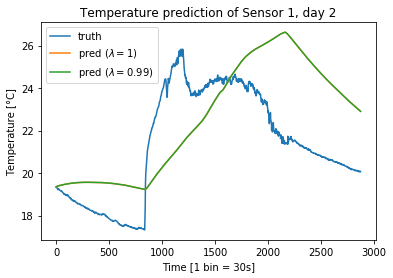

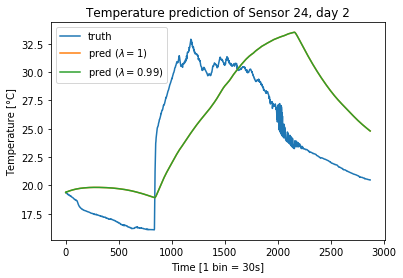

In [45]:
import matplotlib.pyplot as plt

t = np.arange(len(y1))
fig1, ax1 = plt.subplots()
ax1.plot(t, y1, label='truth')
ax1.set_title("Temperature prediction of Sensor 1, day %s" % day)
ax1.set_ylabel("Temperature [°C]")
ax1.set_xlabel("Time [1 bin = 30s]")
ax1.plot(t, y_hat1_mod1, label=r'pred ($\lambda=1$)')
ax1.plot(t, y_hat1_mod2, label=r'pred ($\lambda=0.99$)')
ax1.legend(loc='upper left')

fig24, ax24 = plt.subplots()
ax24.plot(t, y24, label='truth')
ax24.set_title("Temperature prediction of Sensor 24, day %s" % day)
ax24.set_ylabel("Temperature [°C]")
ax24.set_xlabel("Time [1 bin = 30s]")
ax24.plot(t, y_hat24_mod1, label=r'pred ($\lambda=1$)')
ax24.plot(t, y_hat24_mod2, label=r'pred ($\lambda=0.99$)')
ax24.legend(loc='upper left')
plt.show()

fig1.savefig('RLS_day%s_sensor%s_%f_%f.png' %(day, 1, mse1_mod1, mse1_mod2))
fig24.savefig('RLS_day%s_sensor%s_%f_%f.png' %(day, 24, mse24_mod1, mse24_mod2))

In [3]:
i=0 #Initialise counter

n=10   # number of inputs

beta=np.zeros(n) ## first and last parameters are 1, others are zeros
beta[1]=1   
beta[-1]=1
beta.shape=(n,1)


#Loop for sending messages to Kafka with the topic dataLinearModel

while True:
    x=np.random.rand(1,n)[0]
    y=float(x.dot(beta))+0.1*np.random.rand(1)[0] ## y =x^T beta +w
    message=np.array2string(np.append([i,y],x),separator=",") 
    print(message)
    producer.send('dataLinearModel', message.encode())
    i=i+1
    time.sleep(1)

[ 0.        , 0.95772618, 0.67060354, 0.24211019, 0.17263733, 0.79885759,
  0.48056794, 0.98570543, 0.1627009 , 0.58327203, 0.78245165, 0.68484422]
[ 1.        , 0.65940146, 0.10026097, 0.05903539, 0.22909641, 0.32563214,
  0.6809396 , 0.60368021, 0.39138901, 0.26470633, 0.22869574, 0.52838563]
[ 2.        , 0.2607595 , 0.63829029, 0.13070341, 0.41263292, 0.54827117,
  0.04545682, 0.82817345, 0.67135199, 0.6920729 , 0.5594482 , 0.06165693]
[ 3.        , 0.95416609, 0.04906261, 0.12341107, 0.1070854 , 0.00331074,
  0.36320009, 0.2750774 , 0.57627341, 0.03799513, 0.60491055, 0.77024075]
[ 4.        , 1.7365181 , 0.92561066, 0.80130513, 0.36961445, 0.1497974 ,
  0.0540831 , 0.53595227, 0.70130951, 0.77182248, 0.23849375, 0.88075003]
[ 5.        , 1.21626752, 0.92572199, 0.6323603 , 0.83326384, 0.66514895,
  0.12938035, 0.99302658, 0.18598089, 0.5205909 , 0.48324244, 0.51460192]
[ 6.        , 0.86638299, 0.34990381, 0.54791102, 0.95241497, 0.70053108,
  0.23466649, 0.05525377, 0.45685857, 

[ 49.        ,  1.87313449,  0.62510852,  0.99297458,  0.14825713,
   0.33426   ,  0.96796691,  0.38571584,  0.14563271,  0.68380523,
   0.0765593 ,  0.87961825]
[ 50.        ,  0.85262817,  0.37115393,  0.79027126,  0.12221132,
   0.52871574,  0.18528548,  0.94761125,  0.67077707,  0.56343033,
   0.73476217,  0.05936989]
[ 51.        ,  1.53177351,  0.07192952,  0.8356925 ,  0.30456939,
   0.72036634,  0.60152491,  0.10571554,  0.53027396,  0.45361879,
   0.83916123,  0.68076368]
[ 52.        ,  0.54462778,  0.14085798,  0.13559422,  0.60213847,
   0.81927175,  0.40551726,  0.85744463,  0.39721184,  0.37305844,
   0.62073097,  0.33708896]
[  5.30000000e+01,  5.13963328e-01,  4.61748724e-01,  8.03057483e-03,
   3.47863740e-01,  4.84717892e-01,  2.52756041e-01,  7.83358292e-01,
   3.77895161e-01,  4.84854538e-01,  6.85209293e-01,  4.11295530e-01]
[  5.40000000e+01,  6.12267499e-01,  6.67857444e-01,  3.05062782e-03,
   8.59376114e-02,  2.48637159e-01,  7.93277057e-01,  4.25576201e-01,
  

[ 95.        ,  0.74256141,  0.7398143 ,  0.41258847,  0.82803955,
   0.15263898,  0.21054319,  0.42126611,  0.95203626,  0.10866459,
   0.51548958,  0.2905914 ]
[ 96.        ,  1.6696113 ,  0.98821607,  0.77123873,  0.67754367,
   0.43592821,  0.59097779,  0.20514365,  0.47219884,  0.28216909,
   0.4722199 ,  0.84666987]
[  9.70000000e+01,  4.85469055e-01,  6.60786921e-01,  2.33056135e-01,
   3.84478482e-01,  3.91092594e-02,  7.71698443e-01,  1.49730783e-01,
   2.20663948e-01,  7.69490805e-01,  6.71920478e-01,  1.69012289e-01]
[  9.80000000e+01,  1.36440073e+00,  1.98287538e-01,  3.30879059e-01,
   3.45809287e-01,  2.19958074e-01,  1.17128169e-01,  3.16137321e-01,
   7.34358494e-02,  1.84843309e-01,  5.56264035e-01,  9.55274517e-01]
[ 99.        ,  0.78407331,  0.36046046,  0.11776012,  0.67550267,
   0.79697578,  0.86638062,  0.19087129,  0.92443062,  0.22827448,
   0.6916496 ,  0.61069823]
[  1.00000000e+02,  1.05427074e+00,  2.23994077e-01,  2.22770007e-01,
   6.05842881e-01,  3.50

[ 137.        ,   1.56186691,   0.99772438,   0.73882414,   0.83229368,
    0.97996755,   0.77968494,   0.59510207,   0.34350337,   0.97291179,
    0.81865215,   0.78996039]
[  1.38000000e+02,  7.57344521e-01,  1.84121855e-03,  6.36404205e-01,
   8.86699789e-01,  9.81942860e-01,  3.03023302e-01,  4.47183902e-01,
   3.96710388e-01,  4.58223461e-01,  3.27556420e-01,  5.25036817e-02]
[  1.39000000e+02,  4.98088612e-01,  4.56647121e-01,  3.91178471e-01,
   1.91155223e-01,  1.05275659e-01,  2.12562195e-01,  3.22837434e-02,
   3.48470711e-01,  8.48370513e-01,  8.33550996e-01,  1.06781542e-01]
[  1.40000000e+02,  1.92212795e+00,  9.98387534e-01,  9.29409010e-01,
   6.17675495e-01,  6.81671152e-01,  2.64679670e-03,  2.80075024e-01,
   2.14498159e-02,  3.06135621e-01,  2.89395416e-01,  9.45287703e-01]
[  1.41000000e+02,  1.01230413e+00,  8.83800860e-01,  1.12125637e-01,
   7.70669374e-01,  1.91134872e-01,  8.47097335e-01,  5.38594024e-01,
   8.12080883e-01,  9.81414722e-01,  4.82912664e-01,  8.

[  1.78000000e+02,  1.82875554e+00,  6.85009784e-01,  9.62205070e-01,
   2.33256374e-02,  4.96188875e-01,  1.97638018e-01,  2.90406817e-01,
   7.27624227e-01,  4.20159381e-01,  7.42523967e-01,  7.83997807e-01]
[ 179.        ,   0.81341134,   0.54902644,   0.54997082,   0.704293  ,
    0.26121434,   0.73872776,   0.93690926,   0.64383099,   0.57384691,
    0.58668034,   0.23413189]
[  1.80000000e+02,  8.29697063e-01,  1.43703938e-01,  4.55591019e-01,
   9.31675835e-01,  5.55087904e-01,  7.06814862e-02,  6.72866323e-01,
   4.51644377e-01,  8.61214737e-01,  6.61000725e-01,  3.13623451e-01]
[ 181.        ,   0.92105487,   0.58577252,   0.55747535,   0.18783516,
    0.85034097,   0.82093457,   0.31894866,   0.50293326,   0.29657657,
    0.7351163 ,   0.31786376]
[  1.82000000e+02,  1.33262804e+00,  6.22761781e-01,  5.73983404e-01,
   3.46354217e-01,  5.98646880e-02,  4.59793514e-01,  9.72061587e-01,
   3.53080028e-01,  2.44058206e-01,  6.63953027e-01,  6.71737402e-01]
[  1.83000000e+02,  1.

[  2.19000000e+02,  1.52232424e+00,  2.94435038e-01,  5.17974212e-01,
   7.31628761e-01,  8.21507627e-03,  1.37696962e-01,  8.63706904e-01,
   2.15442942e-01,  4.10482911e-01,  5.34053617e-01,  9.30558840e-01]
[  2.20000000e+02,  8.93981474e-01,  6.78031313e-01,  4.98971550e-01,
   8.43419256e-01,  5.17246108e-02,  4.22236392e-03,  6.78908640e-01,
   4.08572853e-01,  2.80855511e-01,  8.77346136e-01,  3.73867061e-01]
[  2.21000000e+02,  1.02867200e+00,  1.37114082e-01,  3.74474724e-01,
   1.39824653e-01,  6.30201472e-01,  5.27514491e-02,  1.55546721e-01,
   3.53721296e-01,  7.49433302e-01,  6.22094467e-01,  5.58719219e-01]
[  2.22000000e+02,  1.41758510e+00,  6.78739913e-02,  4.29769880e-01,
   8.92242018e-01,  3.11614812e-02,  8.19866398e-01,  2.74089879e-01,
   3.93933653e-01,  7.73496980e-01,  3.51457460e-01,  9.67317940e-01]
[  2.23000000e+02,  1.21644562e+00,  7.67136369e-02,  8.74078533e-01,
   4.29372282e-01,  9.39368616e-01,  6.98425433e-01,  1.37329695e-01,
   9.00577398e-01,  

[  2.59000000e+02,  9.21804610e-01,  8.81025149e-01,  5.98463907e-02,
   1.25308028e-01,  7.97221413e-01,  5.26468124e-01,  5.97221169e-01,
   7.56180103e-01,  1.11127410e-01,  3.48878014e-01,  8.59532760e-01]
[  2.60000000e+02,  1.10892291e+00,  8.38355992e-01,  6.71369543e-01,
   8.43517127e-01,  6.92606033e-01,  3.25365642e-01,  1.19906416e-01,
   8.72460866e-01,  5.40435782e-01,  3.17458219e-01,  3.70615578e-01]
[  2.61000000e+02,  1.01373696e+00,  6.32787331e-02,  6.94373043e-01,
   7.28604506e-01,  7.59644155e-01,  2.43176596e-01,  6.98170100e-01,
   3.44032375e-01,  6.18245322e-01,  6.62289125e-01,  2.84650567e-01]
[  2.62000000e+02,  1.02990244e+00,  8.91542202e-01,  7.88932814e-01,
   1.52445833e-01,  4.89390947e-01,  8.37448099e-01,  3.13640470e-01,
   3.51954809e-01,  2.68490924e-01,  9.34797539e-01,  1.53344422e-01]
[  2.63000000e+02,  4.45038113e-01,  2.17660932e-01,  2.79841010e-01,
   1.08898440e-01,  8.66654122e-01,  6.07488436e-02,  5.10911444e-01,
   4.48856088e-01,  

[  2.99000000e+02,  1.06174472e+00,  3.03100166e-01,  1.47760876e-01,
   1.20282542e-01,  7.12303989e-01,  4.19277850e-01,  8.88124125e-01,
   8.63633713e-01,  6.92813643e-01,  2.55863371e-01,  8.88044353e-01]
[  3.00000000e+02,  7.96047208e-01,  8.12009039e-01,  2.47553377e-02,
   2.28740953e-01,  5.05999549e-01,  1.22879474e-01,  4.61715299e-01,
   4.44393358e-01,  9.29285284e-01,  1.26860686e-01,  7.14768131e-01]
[  3.01000000e+02,  1.75520054e+00,  8.53669787e-01,  7.44129656e-01,
   9.53786481e-01,  8.46402510e-01,  5.84660562e-01,  5.61710609e-01,
   2.11651644e-01,  2.45065390e-01,  4.07838127e-02,  9.87382149e-01]
[  3.02000000e+02,  8.45640460e-01,  5.34555820e-01,  5.54810256e-01,
   6.47091176e-01,  3.13049701e-01,  5.92483266e-01,  5.00259298e-01,
   8.89477920e-01,  5.73420687e-01,  8.58084435e-01,  2.58458725e-01]
[  3.03000000e+02,  1.76698678e+00,  6.86137209e-01,  8.77545669e-01,
   1.78887386e-01,  8.65480733e-01,  6.72477197e-01,  6.64758132e-01,
   3.52301421e-01,  

[  3.39000000e+02,  4.72944846e-01,  7.99646771e-01,  4.03747488e-01,
   1.20106340e-02,  5.08223959e-01,  1.74215977e-01,  3.60462012e-02,
   1.91199483e-01,  1.59315988e-01,  7.12895586e-01,  3.05595571e-02]
[  3.40000000e+02,  4.57426466e-01,  4.01728911e-01,  3.70136246e-01,
   5.95981926e-01,  1.91499102e-02,  9.17663702e-02,  1.58054703e-01,
   6.46276694e-01,  6.30856149e-01,  2.83864794e-01,  8.13679283e-02]


KeyboardInterrupt: 